In [16]:
## On titanic data 

In [39]:
import numpy as np
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer


---

### Tip
If asked *why use FunctionTransformer + ColumnTransformer together*:

> **“FunctionTransformer allows custom transformations, and ColumnTransformer applies them selectively to specific features inside a pipeline.”**



In [26]:
df = pd.read_csv("train.csv" , usecols=["Age", "Fare" , "Survived"])

In [27]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [28]:
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [29]:
df["Age"].fillna(df["Age"].mean() , inplace= True)

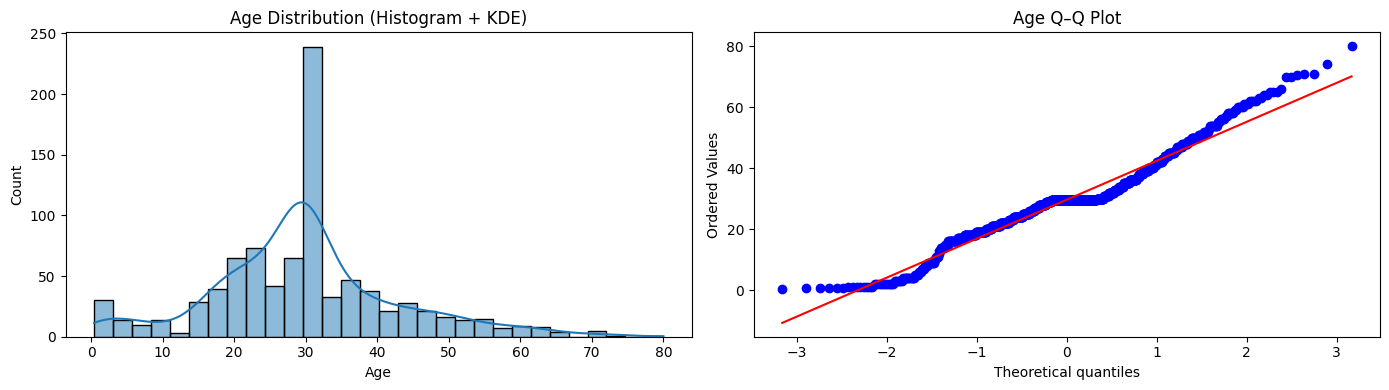

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(df["Age"], kde=True, ax=axes[0])
axes[0].set_title("Age Distribution (Histogram + KDE)")
axes[0].set_xlabel("Age")

# Q-Q Plot
stats.probplot(df["Age"], dist="norm", plot=axes[1])
axes[1].set_title("Age Q–Q Plot")

plt.tight_layout()
plt.show()

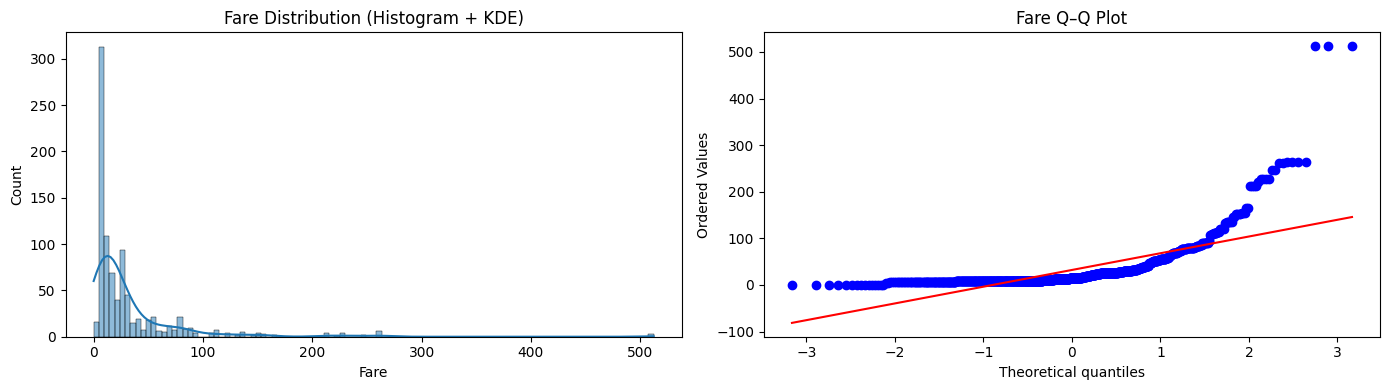

In [32]:
fare = df["Fare"].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram + KDE
sns.histplot(fare, kde=True, ax=axes[0])
axes[0].set_title("Fare Distribution (Histogram + KDE)")
axes[0].set_xlabel("Fare")

# Q-Q Plot
stats.probplot(fare, dist="norm", plot=axes[1])
axes[1].set_title("Fare Q–Q Plot")

plt.tight_layout()
plt.show()

In [33]:
## right skewed fare data 

## without tranformation

In [35]:
from sklearn.model_selection import train_test_split

X = df[["Age", "Fare"]]
y = df["Survived"]

In [36]:
df.isnull().sum()

Survived    0
Age         0
Fare        0
dtype: int64

In [37]:
X_train , X_test , y_train , y_test = train_test_split(
    X, y , test_size=0.2 , random_state=42 , stratify=y
)

# Why stratify=y?
# Keeps survival ratio same in train & test
# Very important for imbalanced datasets like Titanic

In [40]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()

In [41]:
clf1.fit(X_train , y_train)
clf2.fit(X_train , y_train)

y_pred = clf1.predict(X_test)
y_pred1 = clf2.predict(X_test)

print("Accuracy Logistic Regression:", accuracy_score(y_test, y_pred))
print("Accuracy Decision Tree:", accuracy_score(y_test, y_pred1))

Accuracy Logistic Regression: 0.6089385474860335
Accuracy Decision Tree: 0.547486033519553


In [43]:
trf = FunctionTransformer(func = np.log1p)

In [44]:
X_train_transformed = trf.fit_transform(X_train)
X_test_transformed = trf.transform(X_test)

In [48]:
clf = LogisticRegression()
clf2 = DecisionTreeClassifier()

clf.fit(X_train_transformed , y_train)
clf2.fit(X_train_transformed , y_train)

y_pred = clf.predict(X_test_transformed)
y_pred1 = clf2.predict(X_test_transformed)

print("Acuuracy LR" , accuracy_score(y_test , y_pred))
print("Accuracy DT" , accuracy_score(y_test , y_pred1))

Acuuracy LR 0.6256983240223464
Accuracy DT 0.5586592178770949


In [49]:
## actually accuracy improved on LR

In [50]:
## lets do cross Validation

In [52]:
X_transformed = trf.fit_transform(X)

clf = LogisticRegression()
clf2 = DecisionTreeClassifier()

print("LR" , np.mean(cross_val_score(clf ,X_transformed , y , scoring="accuracy" , cv=10 )))
print("DT" , np.mean(cross_val_score(clf2 , X_transformed , y , scoring = "accuracy" ,cv=10)))

LR 0.678027465667915
DT 0.6588639200998753


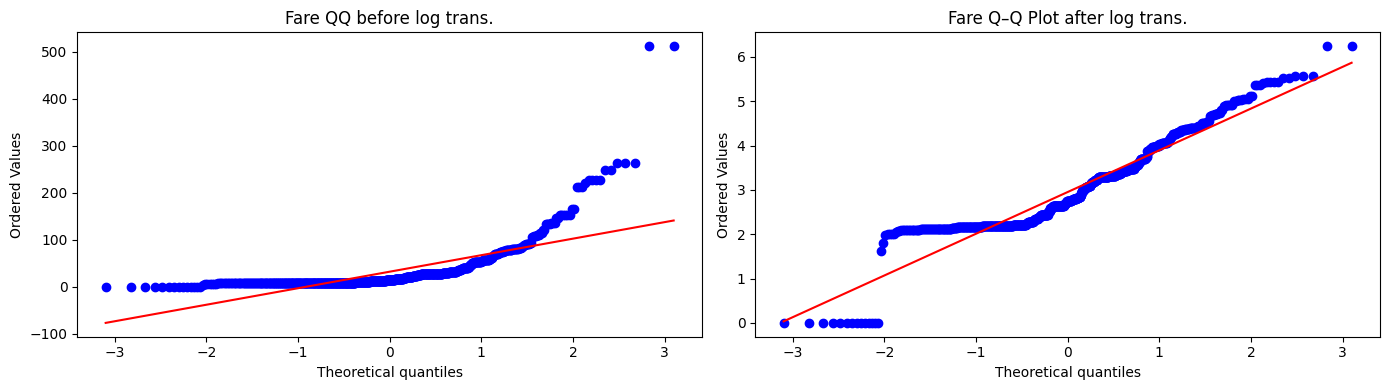

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

stats.probplot(X_train["Fare"], dist="norm", plot=axes[0])
axes[0].set_title("Fare QQ before log trans.")


stats.probplot(X_train_transformed["Fare"], dist="norm", plot=axes[1])
axes[1].set_title("Fare Q–Q Plot after log trans.")

plt.tight_layout()
plt.show()

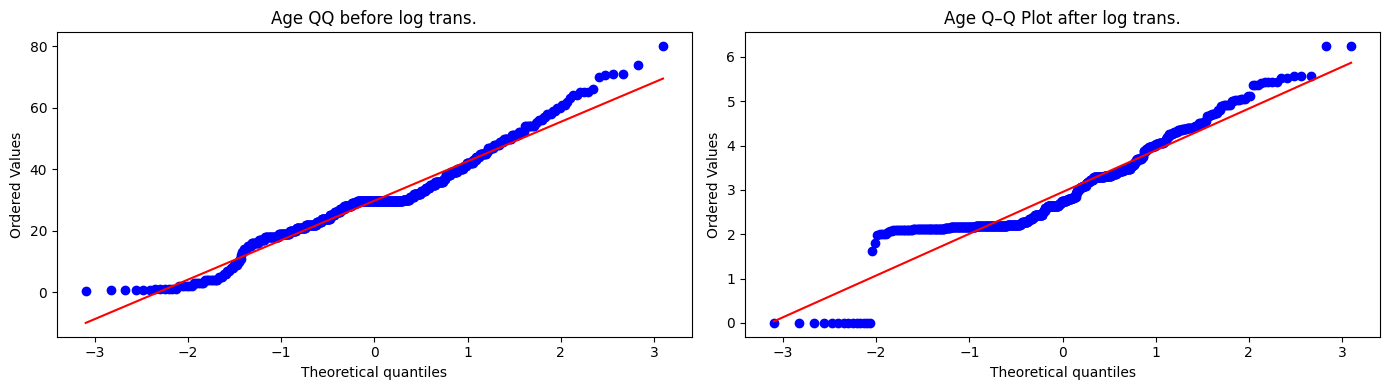

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

stats.probplot(X_train["Age"], dist="norm", plot=axes[0])
axes[0].set_title("Age QQ before log trans.")


stats.probplot(X_train_transformed["Fare"], dist="norm", plot=axes[1])
axes[1].set_title("Age Q–Q Plot after log trans.")

plt.tight_layout()
plt.show()

In [56]:
## Let's apply transformation only on Fare

### Professional Way(using pipeline)

In [57]:
import pandas as pd

df = pd.read_csv(
    "train.csv",
    usecols=["Age", "Fare", "Survived"]
)

X = df[["Age", "Fare"]]
y = df["Survived"]


In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [60]:
# Age pipeline

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

age_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]
)

In [61]:
# Fare pipeline
fare_pipeline = Pipeline(
    steps=[
        ("log", FunctionTransformer(np.log1p)),
        ("scaler", StandardScaler())
    ]
)

In [63]:
## column tranformation
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("age", age_pipeline, ["Age"]),
        ("fare", fare_pipeline, ["Fare"])
    ]
)

In [64]:
## LR pipeline 
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

In [65]:
## Decision Tree Pipeline
from sklearn.tree import DecisionTreeClassifier

pipe_dt = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", DecisionTreeClassifier(random_state=42))
    ]
)

In [66]:
pipe_lr.fit(X_train, y_train)
pipe_dt.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('age', ...), ('fare', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [67]:
from sklearn.metrics import accuracy_score

y_pred_lr = pipe_lr.predict(X_test)
y_pred_dt = pipe_dt.predict(X_test)

print("Accuracy Logistic Regression:", accuracy_score(y_test, y_pred_lr))
print("Accuracy Decision Tree:", accuracy_score(y_test, y_pred_dt))

Accuracy Logistic Regression: 0.6201117318435754
Accuracy Decision Tree: 0.547486033519553


#### Cross val score 

In [69]:
from sklearn.model_selection import cross_val_score

cv_scores_lr = cross_val_score(pipe_lr, X, y, cv=15,scoring="accuracy"
)
print("Logistic Regression CV Accuracy:",cv_scores_lr.mean())


Logistic Regression CV Accuracy: 0.6679472693032015


In [71]:
cv_scores_dt = cross_val_score(pipe_dt,X, y,
    cv=15,
    scoring="accuracy"
)

print("Decision Tree CV Accuracy:",cv_scores_dt.mean())


Decision Tree CV Accuracy: 0.6632391713747645


### Other Transformations

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

fare = df["Fare"]

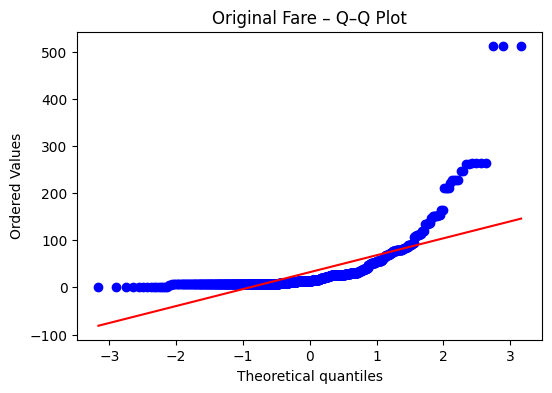

In [74]:
plt.figure(figsize=(6,4))
stats.probplot(fare, dist="norm", plot=plt)
plt.title("Original Fare – Q–Q Plot")
plt.show()

In [76]:
fare_reciprocal = 1 / (fare + 1)

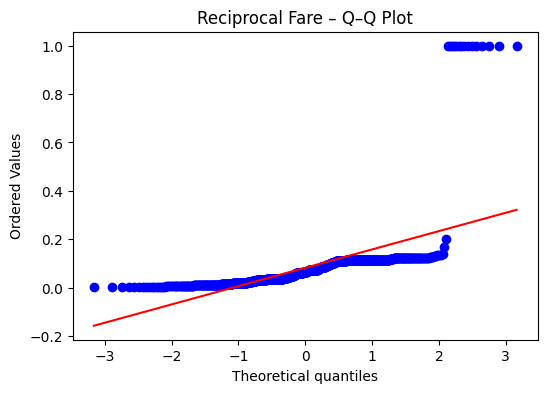

In [77]:
plt.figure(figsize=(6,4))
stats.probplot(fare_reciprocal, dist="norm", plot=plt)
plt.title("Reciprocal Fare – Q–Q Plot")
plt.show()

## Reciprocal Fare – Q–Q Plot Analysis

### What transformation was applied
\[
f(x) = \frac{1}{x}
\]
(A small constant is usually added in practice to avoid division by zero.)

---

### Key observations from the Q–Q plot

- Points are **flattened near zero** for most quantiles  
- Upper quantiles cluster tightly around a small range
- The distribution is no longer right-skewed; it is **strongly left-skewed**
- Points deviate from the diagonal line in a systematic way

---

### What this transformation did to Fare

- **Aggressively compresses large Fare values**
- Loses meaningful scale differences between medium and large fares
- Flips the skewness direction (right → left)
- Introduces distortion rather than normalization

---

### Interpretation

The reciprocal transformation is **too aggressive** for Fare:
- It over-corrects the right skew
- Makes the data less interpretable
- Does not produce a normal-like distribution

---

### Practical verdict

-  Not suitable for normalizing Fare
- Rarely used in real ML pipelines
- Mostly useful for **theoretical understanding**, not modeling

---

### One-line takeaway

> **Reciprocal transformation over-compresses Fare values and flips the skewness, making the distribution unsuitable for most ML models.**


Square Transformation (x²)

In [79]:
fare_square = fare ** 2

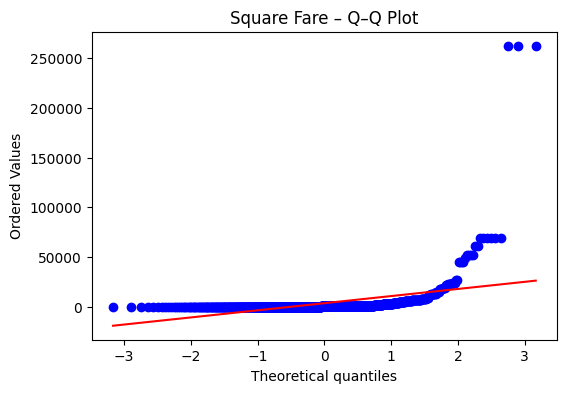

In [80]:
plt.figure(figsize=(6,4))
stats.probplot(fare_square, dist="norm", plot=plt)
plt.title("Square Fare – Q–Q Plot")
plt.show()

## Square Fare – Q–Q Plot Analysis

### What transformation was applied
\[
f(x) = x^2
\]

---

### Key observations from the Q–Q plot

- Extreme upward deviation at the right tail
- Upper quantiles are **far above** the diagonal line
- Outliers are massively stretched
- Curvature is stronger than in the original Fare plot

---

### What this transformation did to Fare

- **Amplified existing right skewness**
- Increased variance dramatically
- Made large Fare values dominate the distribution
- Pushed the data further away from normality

---

### Interpretation

Square transformation is **counterproductive** for right-skewed data:
- Instead of compressing large values, it expands them
- Makes distribution more extreme and unstable
- Worsens model behavior for linear and distance-based algorithms

---

### Practical verdict

- Should not be used for normalizing Fare
- Increases skewness and outlier impact
- Useful only when intentionally emphasizing large values (rare case)

---

### One-line takeaway

> **Square transformation magnifies right skew and exaggerates outliers, making Fare significantly less normal than before.**


Square Root Transformation (√x)

In [81]:
fare_sqrt = np.sqrt(fare)

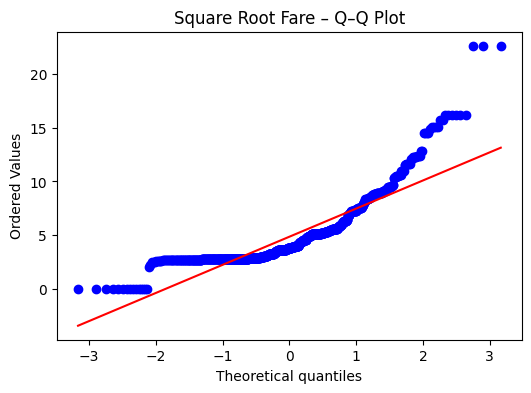

In [82]:
plt.figure(figsize=(6,4))
stats.probplot(fare_sqrt, dist="norm", plot=plt)
plt.title("Square Root Fare – Q–Q Plot")
plt.show()

## Square Root Fare – Q–Q Plot Analysis

### What transformation was applied
\[
f(x) = \sqrt{x}
\]

---

### Key observations from the Q–Q plot

- Right tail is noticeably compressed compared to the original Fare
- Points are closer to the diagonal line across most quantiles
- Mild deviation still exists at extreme upper values
- Lower and middle quantiles show improved linear alignment

---

### What this transformation did to Fare

- **Reduced right skewness**
- Compressed large Fare values without destroying scale
- Lowered the influence of extreme outliers
- Improved symmetry of the distribution

---

### Interpretation

Square root transformation provides a **moderate correction**:
- Effective for moderately right-skewed data
- Less aggressive than log transformation
- Does not fully normalize Fare, but improves it significantly

---

### Practical verdict

- Suitable for reducing right skew in Fare
- Safe and interpretable
- May be insufficient if strong normalization is required

---

### One-line takeaway

> **Square root transformation moderately reduces right skewness and brings Fare closer to a normal-like distribution without over-compression.**
